#### Benchmaking Experiment 001
- Model : Model2
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model2(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, max_len=1024, dropout=0.1):
        super(Model2, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> LSTM 
        self.lstmL = nn.LSTM(input_size=d_model, hidden_size=ft_size, batch_first=True)
        self.DensePostL = nn.Linear(in_features=ft_size, out_features=ft_size)
        

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        lstm_out, hidden = self.lstmL(out)
        out = self.DensePostL(lstm_out[:, -1, :])
        return out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 50.88batch/s, loss=0.195]


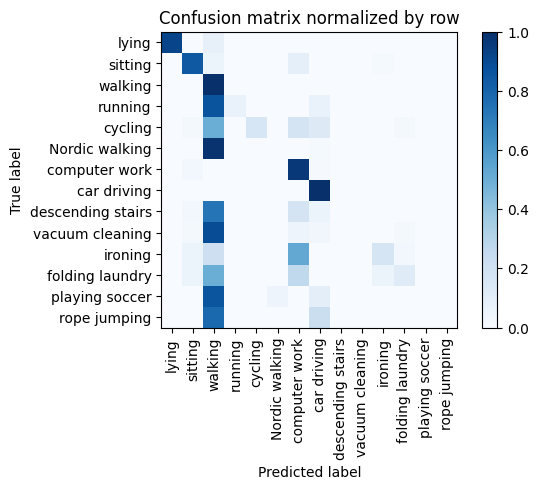

Training Epoch:  10%|█         | 1/10 [00:08<01:19,  8.80s/it]

Overall accuracy: 0.485



eval: 100%|██████████| 26/26 [00:00<00:00, 71.43batch/s, loss=0.145]


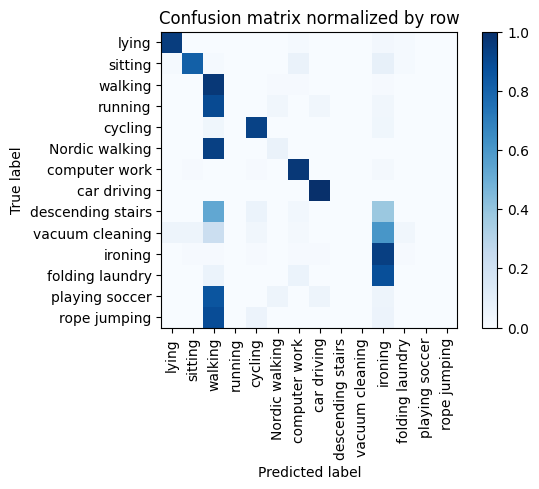

Training Epoch:  20%|██        | 2/10 [00:13<00:51,  6.44s/it]

Overall accuracy: 0.626



eval: 100%|██████████| 26/26 [00:00<00:00, 62.50batch/s, loss=0.123]


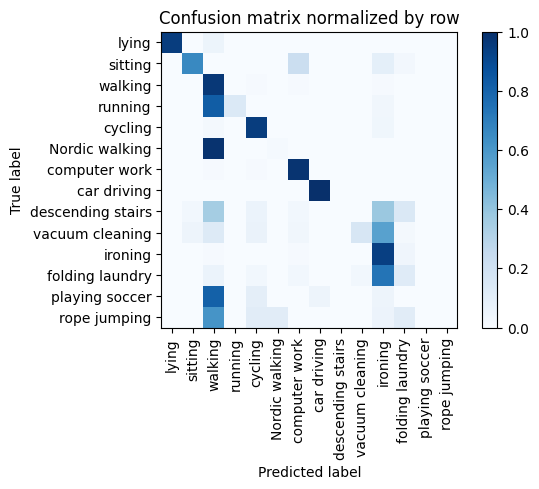

Training Epoch:  30%|███       | 3/10 [00:17<00:38,  5.50s/it]

Overall accuracy: 0.632



eval: 100%|██████████| 26/26 [00:00<00:00, 59.21batch/s, loss=0.111]


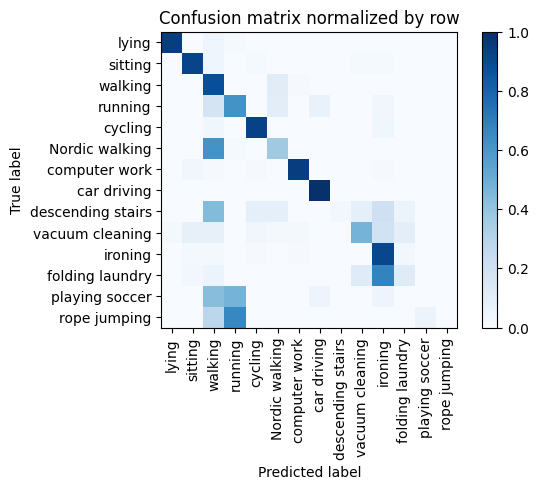

Training Epoch:  40%|████      | 4/10 [00:22<00:30,  5.10s/it]

Overall accuracy: 0.712



eval: 100%|██████████| 26/26 [00:00<00:00, 62.65batch/s, loss=0.11]


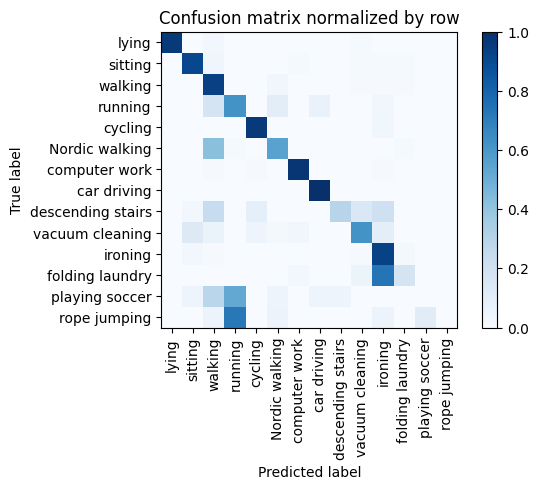

Training Epoch:  50%|█████     | 5/10 [00:26<00:24,  4.85s/it]

Overall accuracy: 0.769



eval: 100%|██████████| 26/26 [00:00<00:00, 56.52batch/s, loss=0.0581]


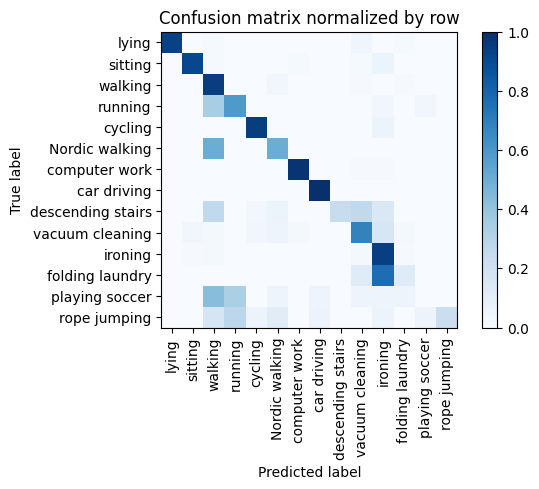

Training Epoch:  60%|██████    | 6/10 [00:31<00:18,  4.71s/it]

Overall accuracy: 0.768



eval: 100%|██████████| 26/26 [00:00<00:00, 62.35batch/s, loss=0.119]


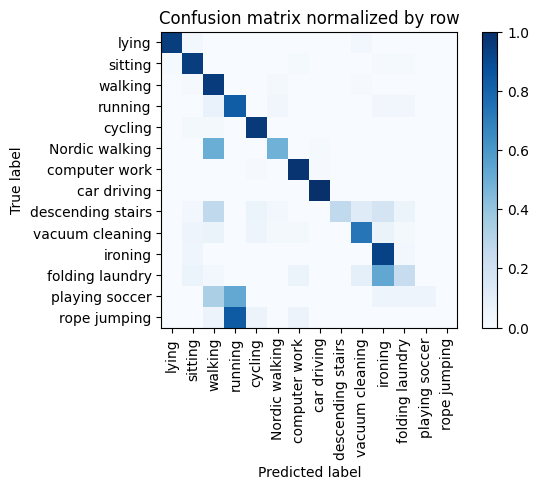

Training Epoch:  70%|███████   | 7/10 [00:35<00:13,  4.51s/it]

Overall accuracy: 0.788



eval: 100%|██████████| 26/26 [00:00<00:00, 50.34batch/s, loss=0.0989]


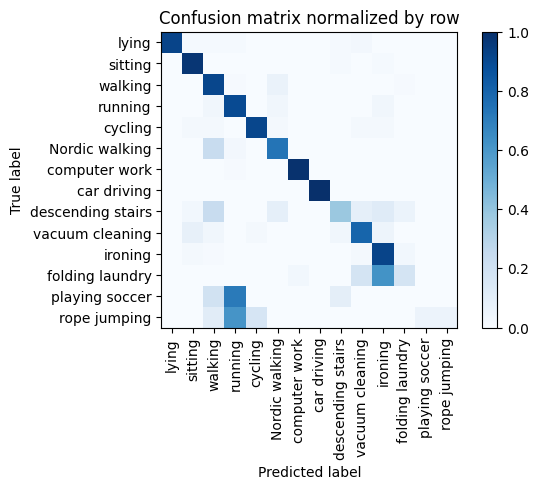

Training Epoch:  80%|████████  | 8/10 [00:39<00:09,  4.52s/it]

Overall accuracy: 0.812



eval: 100%|██████████| 26/26 [00:00<00:00, 58.96batch/s, loss=0.125]


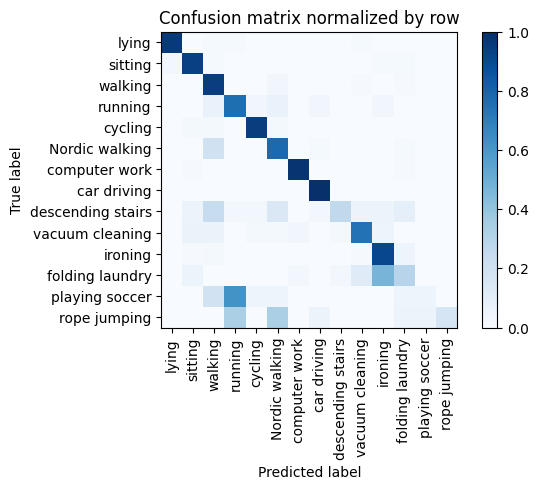

Training Epoch:  90%|█████████ | 9/10 [00:44<00:04,  4.59s/it]

Overall accuracy: 0.815



eval: 100%|██████████| 26/26 [00:00<00:00, 50.58batch/s, loss=0.113]


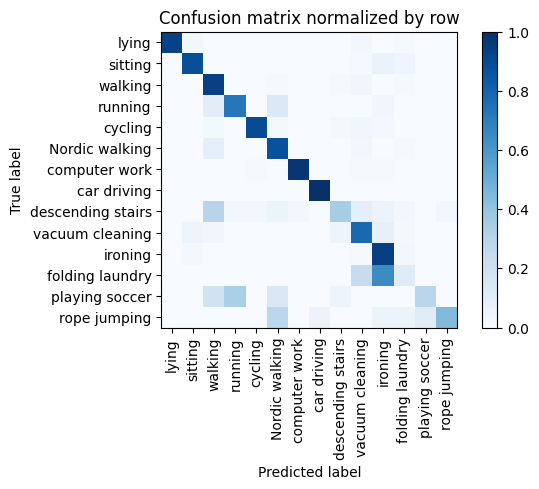

Overall accuracy: 0.823



eval: 100%|██████████| 28/28 [00:00<00:00, 65.27batch/s, loss=0.37] 


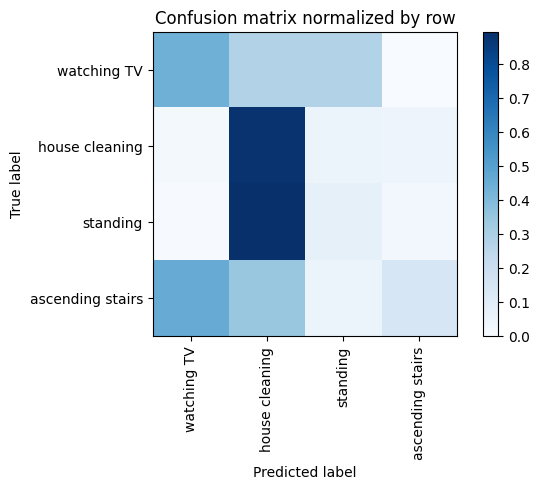

Overall accuracy: 0.405

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.268      0.075      0.117      0.336        294|	 house cleaning: 0.895,	ascending stairs: 0.024,	
  house cleaning       0.416      0.882      0.565      0.329        288|	 standing: 0.056,	ascending stairs: 0.045,	
ascending stairs       0.545      0.142      0.225      0.193        169|	 watching TV: 0.456,	house cleaning: 0.349,	
     watching TV       0.396      0.440      0.417      0.143        125|	 standing: 0.280,	house cleaning: 0.280,	

----------------------------------------------------------------------------------------------------
     avg / total       0.388      0.405      0.328        1.0        876|	      

{'total_accuracy': 0.4052511415525114, 'precision': 0.4062856573114065, 'recall': 0.38469655268419006, 'f1': 0.3310280896242164}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sittin

eval: 100%|██████████| 26/26 [00:00<00:00, 56.77batch/s, loss=0.229]


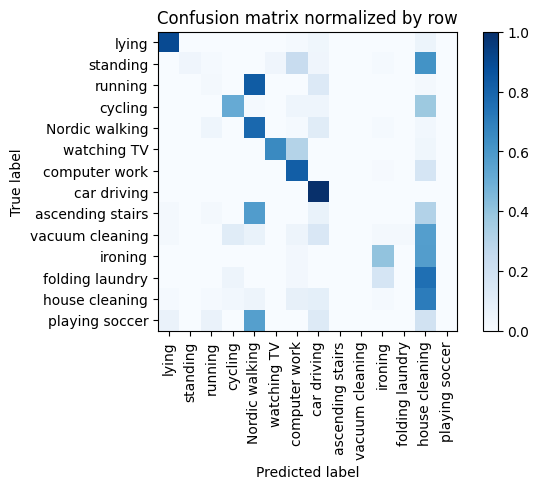

Training Epoch:  10%|█         | 1/10 [00:04<00:42,  4.68s/it]

Overall accuracy: 0.453



eval: 100%|██████████| 26/26 [00:00<00:00, 56.52batch/s, loss=0.167]


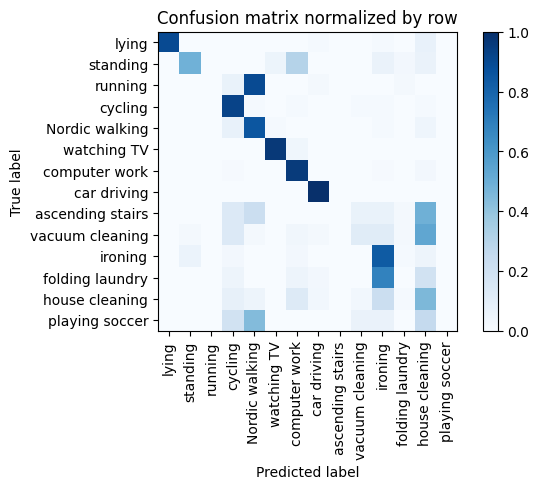

Training Epoch:  20%|██        | 2/10 [00:09<00:36,  4.60s/it]

Overall accuracy: 0.594



eval: 100%|██████████| 26/26 [00:00<00:00, 55.91batch/s, loss=0.126]


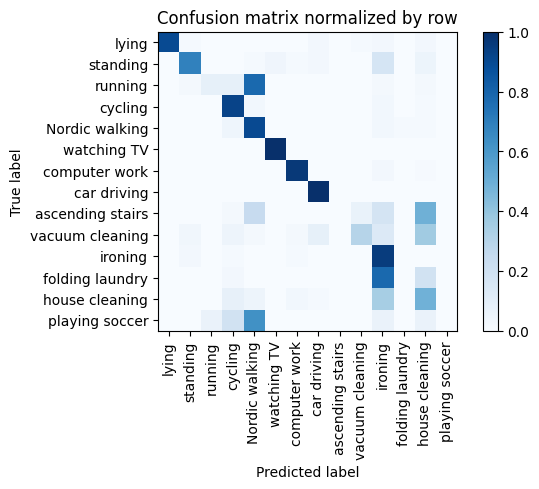

Training Epoch:  30%|███       | 3/10 [00:13<00:30,  4.41s/it]

Overall accuracy: 0.653



eval: 100%|██████████| 26/26 [00:00<00:00, 52.00batch/s, loss=0.184]


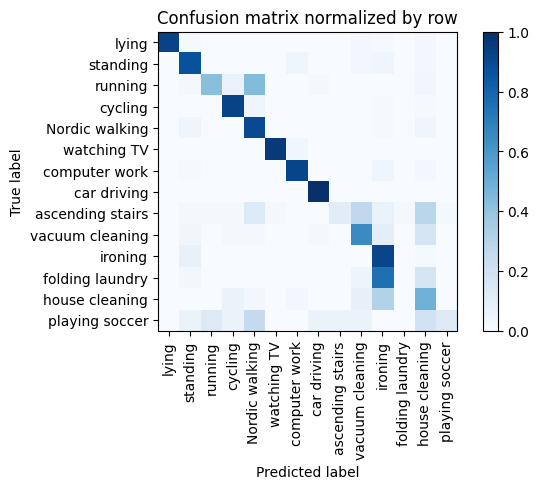

Training Epoch:  40%|████      | 4/10 [00:17<00:26,  4.46s/it]

Overall accuracy: 0.721



eval: 100%|██████████| 26/26 [00:00<00:00, 55.56batch/s, loss=0.186]


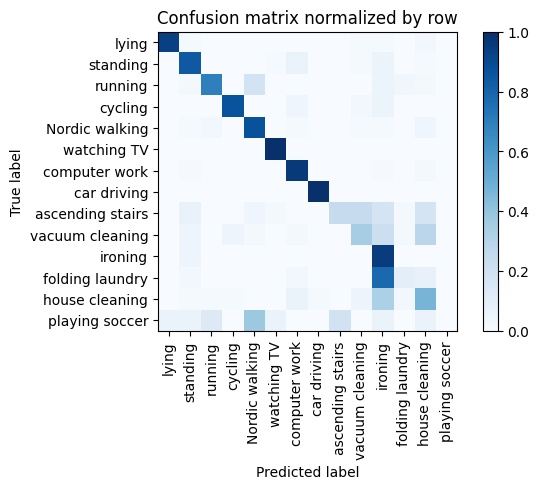

Training Epoch:  50%|█████     | 5/10 [00:22<00:21,  4.36s/it]

Overall accuracy: 0.729



eval: 100%|██████████| 26/26 [00:00<00:00, 69.24batch/s, loss=0.0859]


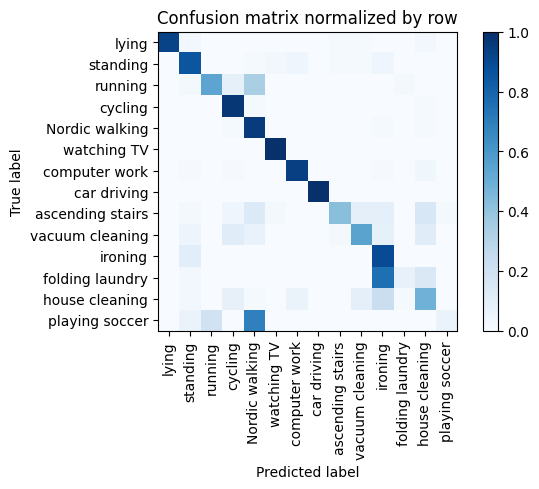

Training Epoch:  60%|██████    | 6/10 [00:25<00:16,  4.18s/it]

Overall accuracy: 0.750



eval: 100%|██████████| 26/26 [00:00<00:00, 72.42batch/s, loss=0.0836]


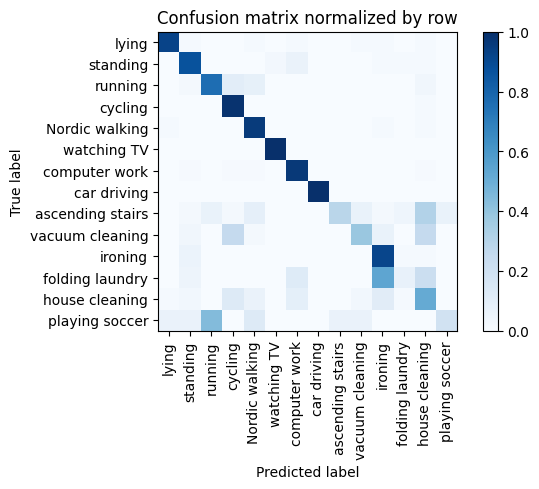

Training Epoch:  70%|███████   | 7/10 [00:32<00:14,  4.86s/it]

Overall accuracy: 0.760



eval: 100%|██████████| 26/26 [00:00<00:00, 73.45batch/s, loss=0.0919]


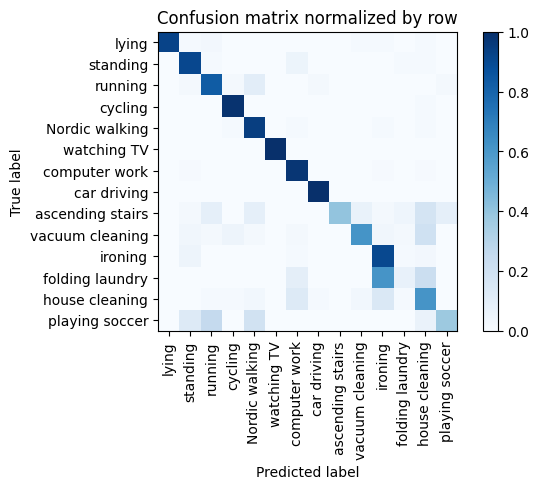

Training Epoch:  80%|████████  | 8/10 [00:36<00:09,  4.63s/it]

Overall accuracy: 0.801



eval: 100%|██████████| 26/26 [00:00<00:00, 75.14batch/s, loss=0.101]


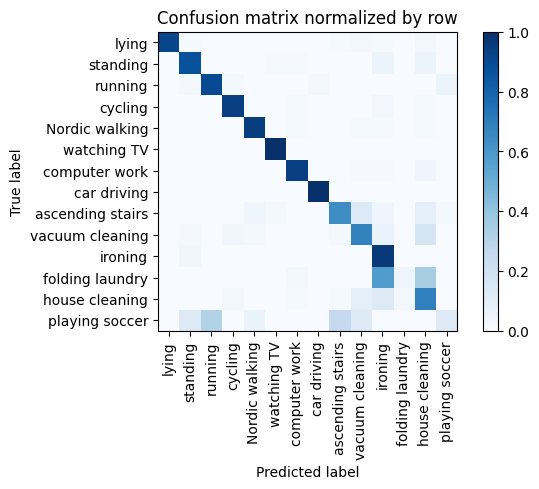

Training Epoch:  90%|█████████ | 9/10 [00:40<00:04,  4.53s/it]

Overall accuracy: 0.817



eval: 100%|██████████| 26/26 [00:00<00:00, 73.76batch/s, loss=0.0874]


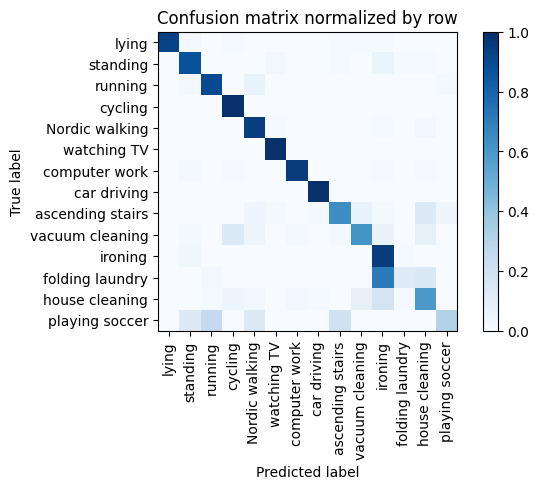

Overall accuracy: 0.820



eval: 100%|██████████| 28/28 [00:00<00:00, 69.59batch/s, loss=0.377]


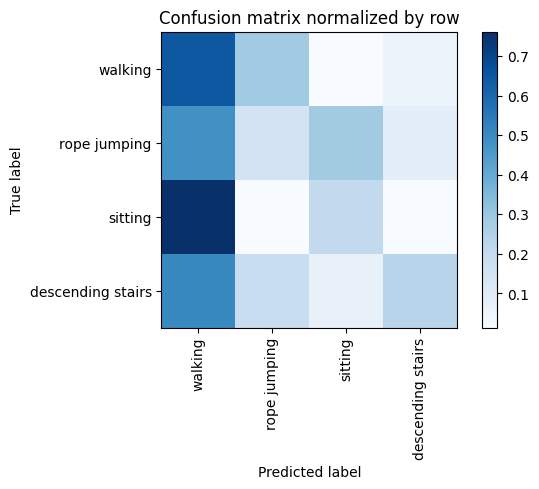

Overall accuracy: 0.391

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.421      0.647      0.510      0.418        365|	 rope jumping: 0.288,	descending stairs: 0.052,	
          sitting       0.594      0.209      0.309      0.313        273|	 walking: 0.762,	descending stairs: 0.015,	
descending stairs       0.545      0.234      0.327      0.176        154|	 walking: 0.506,	rope jumping: 0.188,	
     rope jumping       0.080      0.148      0.104      0.093         81|	 walking: 0.481,	sitting: 0.284,	

----------------------------------------------------------------------------------------------------
      avg / total       0.465      0.391      0.377        1.0        873|	      

{'total_accuracy': 0.39060710194730813, 'precision': 0.4099704768270944, 'recall': 0.30932023329283603, 'f1': 0.31245778576548217}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleani

eval: 100%|██████████| 24/24 [00:00<00:00, 58.68batch/s, loss=0.226]


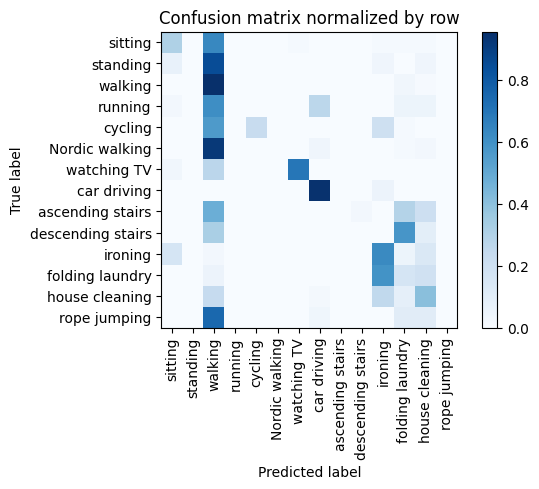

Training Epoch:  10%|█         | 1/10 [00:03<00:35,  3.89s/it]

Overall accuracy: 0.328



eval: 100%|██████████| 24/24 [00:00<00:00, 61.38batch/s, loss=0.134]


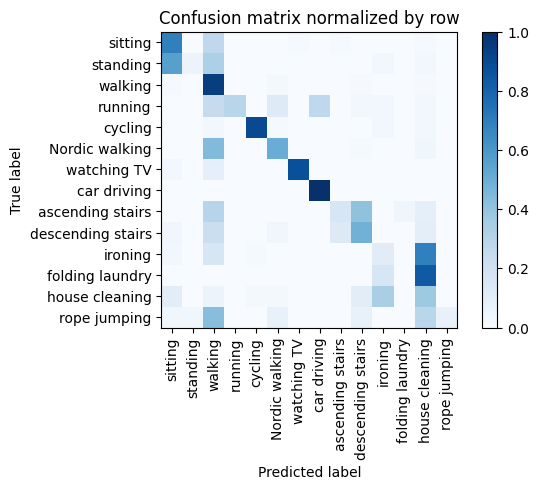

Training Epoch:  20%|██        | 2/10 [00:07<00:31,  3.95s/it]

Overall accuracy: 0.475



eval: 100%|██████████| 24/24 [00:00<00:00, 74.30batch/s, loss=0.149]


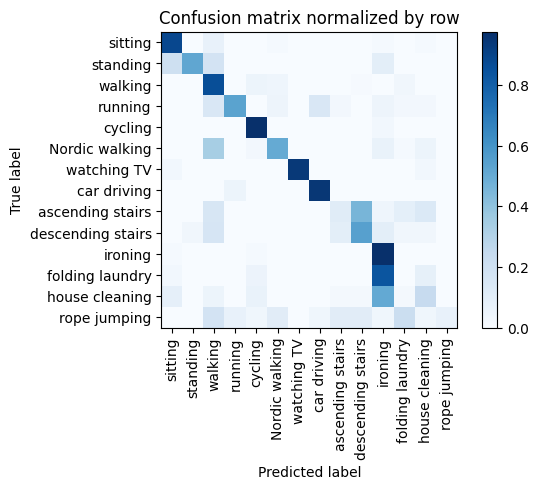

Training Epoch:  30%|███       | 3/10 [00:11<00:27,  3.95s/it]

Overall accuracy: 0.629



eval: 100%|██████████| 24/24 [00:00<00:00, 66.48batch/s, loss=0.117]


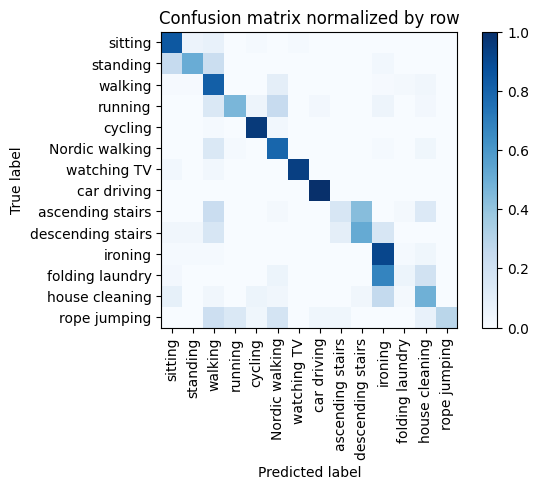

Training Epoch:  40%|████      | 4/10 [00:15<00:22,  3.83s/it]

Overall accuracy: 0.669



eval: 100%|██████████| 24/24 [00:00<00:00, 59.85batch/s, loss=0.177]


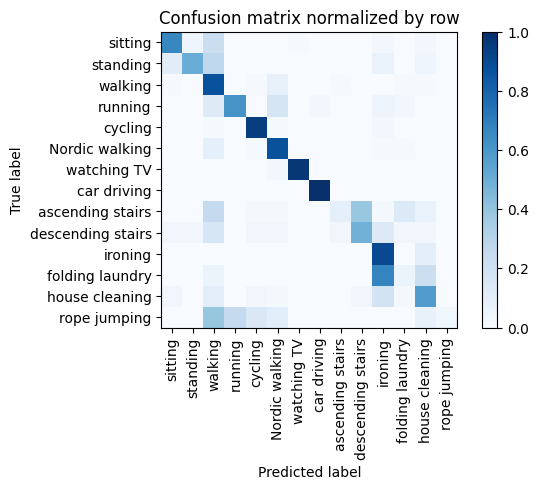

Training Epoch:  50%|█████     | 5/10 [00:19<00:19,  3.83s/it]

Overall accuracy: 0.665



eval: 100%|██████████| 24/24 [00:00<00:00, 57.34batch/s, loss=0.115]


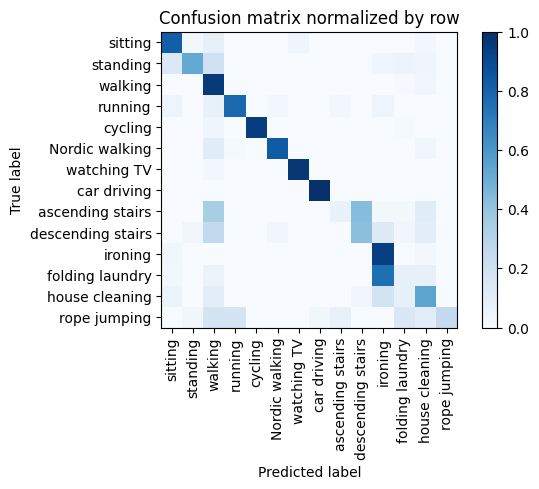

Training Epoch:  60%|██████    | 6/10 [00:23<00:15,  3.85s/it]

Overall accuracy: 0.703



eval: 100%|██████████| 24/24 [00:00<00:00, 54.55batch/s, loss=0.144]


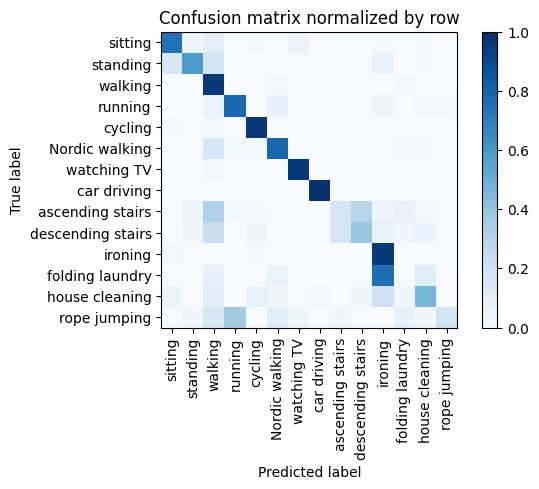

Training Epoch:  70%|███████   | 7/10 [00:27<00:11,  3.92s/it]

Overall accuracy: 0.695



eval: 100%|██████████| 24/24 [00:00<00:00, 58.23batch/s, loss=0.149]


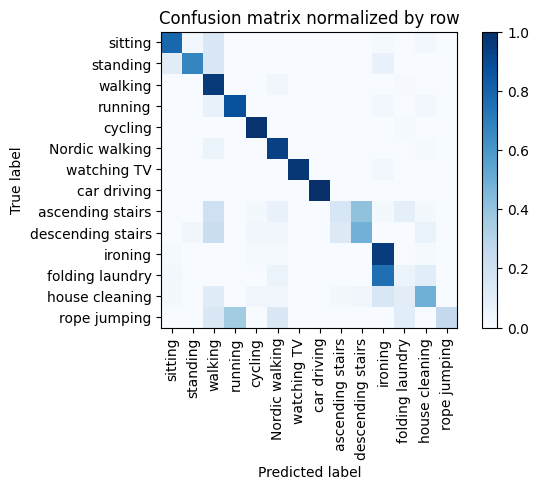

Training Epoch:  80%|████████  | 8/10 [00:31<00:08,  4.06s/it]

Overall accuracy: 0.739



eval: 100%|██████████| 24/24 [00:00<00:00, 57.42batch/s, loss=0.061]


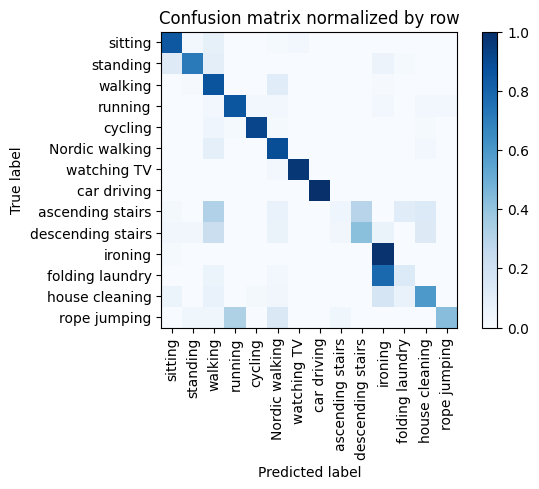

Training Epoch:  90%|█████████ | 9/10 [00:35<00:04,  4.01s/it]

Overall accuracy: 0.736



eval: 100%|██████████| 24/24 [00:00<00:00, 56.87batch/s, loss=0.121]


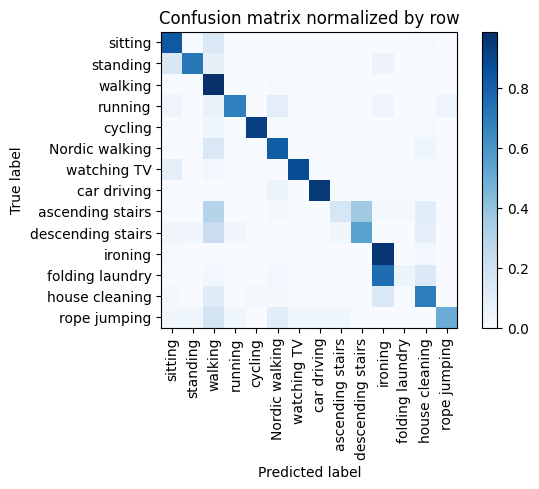

Overall accuracy: 0.747



eval: 100%|██████████| 35/35 [00:00<00:00, 56.58batch/s, loss=0.362]


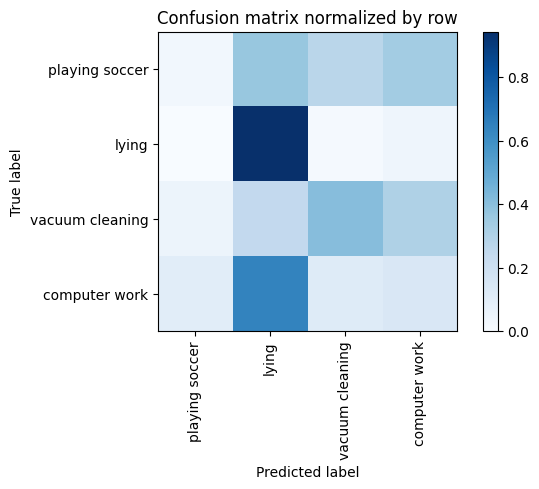

Overall accuracy: 0.414

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.355      0.143      0.203      0.419        463|	 lying: 0.639,	vacuum cleaning: 0.117,	
          lying       0.419      0.943      0.580      0.269        297|	 computer work: 0.044,	vacuum cleaning: 0.013,	
vacuum cleaning       0.585      0.406      0.479      0.245        271|	 computer work: 0.303,	lying: 0.244,	
 playing soccer       0.032      0.027      0.029      0.067         74|	 lying: 0.365,	computer work: 0.338,	vacuum cleaning: 0.270,	

----------------------------------------------------------------------------------------------------
    avg / total       0.407      0.414      0.361        1.0       1105|	      

{'total_accuracy': 0.4144796380090498, 'precision': 0.34768457105689454, 'recall': 0.3795601562352178, 'f1': 0.32295364309647545}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic wa

eval: 100%|██████████| 27/27 [00:00<00:00, 59.08batch/s, loss=0.18]


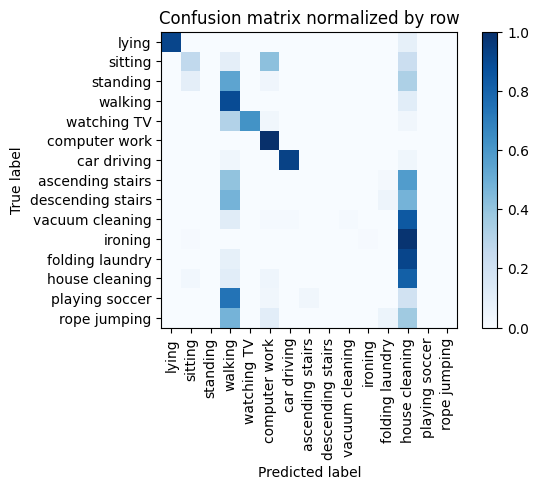

Training Epoch:  10%|█         | 1/10 [00:04<00:37,  4.12s/it]

Overall accuracy: 0.409



eval: 100%|██████████| 27/27 [00:00<00:00, 30.35batch/s, loss=0.139]


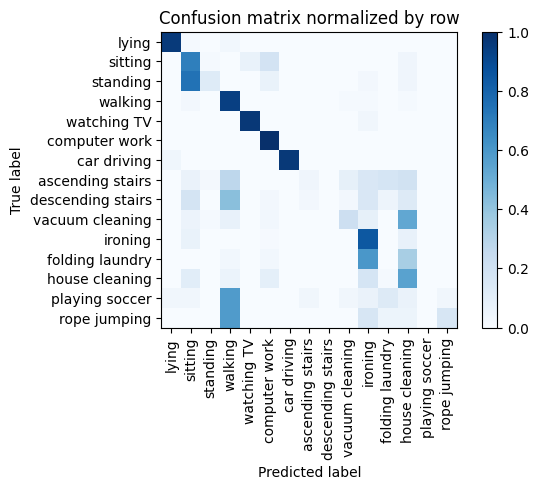

Training Epoch:  20%|██        | 2/10 [00:09<00:39,  4.88s/it]

Overall accuracy: 0.578



eval: 100%|██████████| 27/27 [00:00<00:00, 56.60batch/s, loss=0.192]


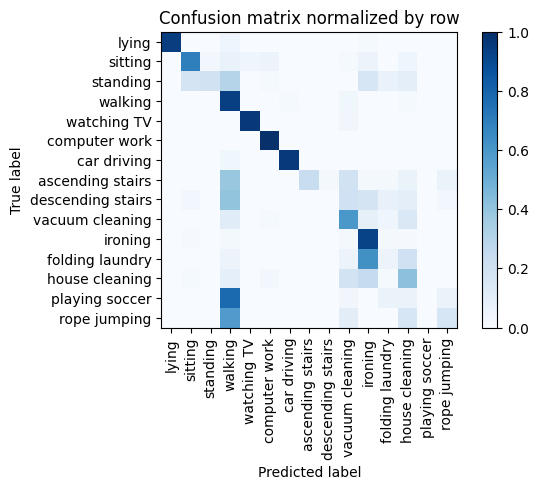

Training Epoch:  30%|███       | 3/10 [00:15<00:36,  5.27s/it]

Overall accuracy: 0.626



eval: 100%|██████████| 27/27 [00:00<00:00, 59.43batch/s, loss=0.116]


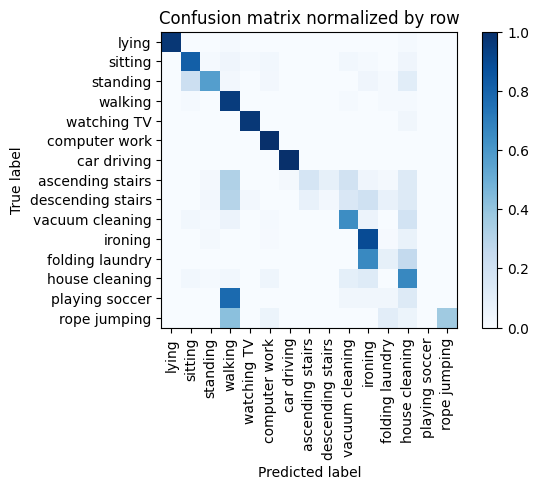

Training Epoch:  40%|████      | 4/10 [00:19<00:29,  4.84s/it]

Overall accuracy: 0.695



eval: 100%|██████████| 27/27 [00:00<00:00, 67.84batch/s, loss=0.127]


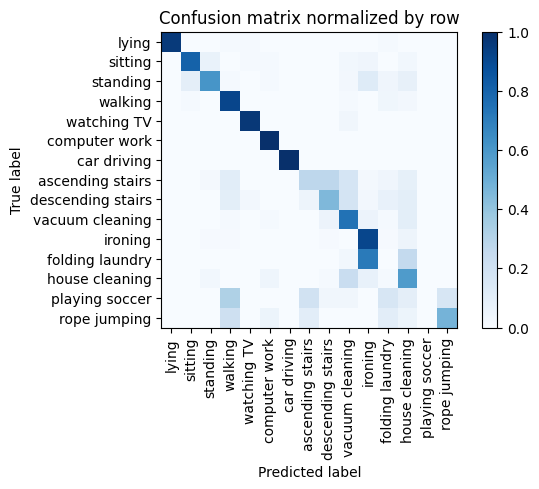

Training Epoch:  50%|█████     | 5/10 [00:23<00:23,  4.70s/it]

Overall accuracy: 0.722



eval: 100%|██████████| 27/27 [00:00<00:00, 65.06batch/s, loss=0.126]


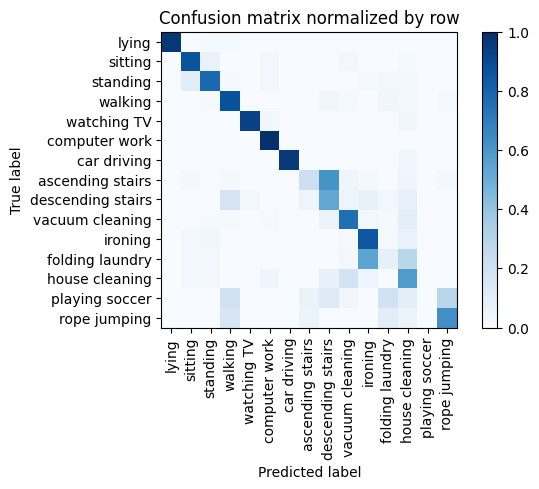

Training Epoch:  60%|██████    | 6/10 [00:28<00:18,  4.63s/it]

Overall accuracy: 0.736



eval: 100%|██████████| 27/27 [00:00<00:00, 46.99batch/s, loss=0.0896]


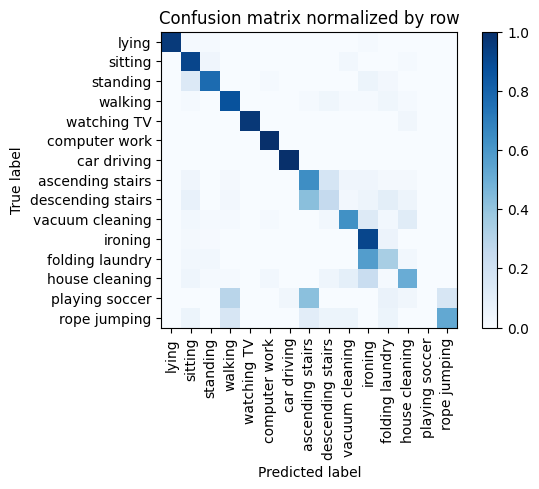

Training Epoch:  70%|███████   | 7/10 [00:32<00:13,  4.60s/it]

Overall accuracy: 0.751



eval: 100%|██████████| 27/27 [00:00<00:00, 59.08batch/s, loss=0.116]


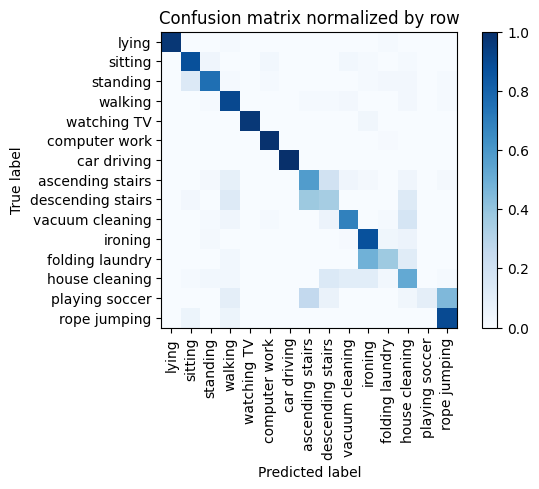

Training Epoch:  80%|████████  | 8/10 [00:37<00:09,  4.63s/it]

Overall accuracy: 0.765



eval: 100%|██████████| 27/27 [00:00<00:00, 29.83batch/s, loss=0.134]


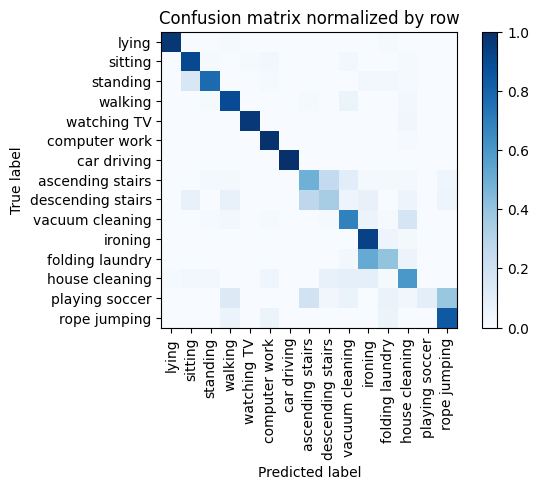

Training Epoch:  90%|█████████ | 9/10 [00:42<00:04,  4.81s/it]

Overall accuracy: 0.775



eval: 100%|██████████| 27/27 [00:00<00:00, 60.44batch/s, loss=0.13]


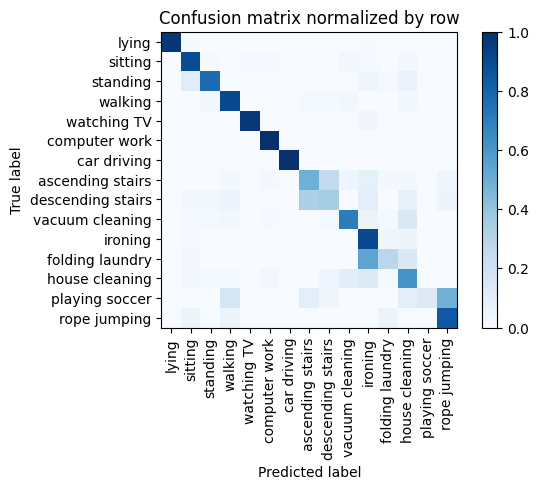

Overall accuracy: 0.772



eval: 100%|██████████| 22/22 [00:00<00:00, 43.71batch/s, loss=0.563]


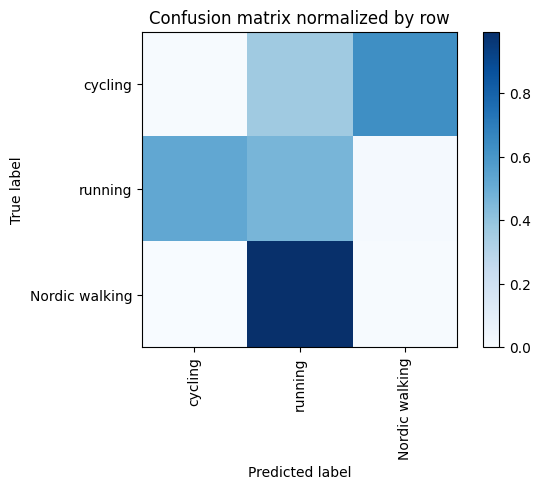

Overall accuracy: 0.104

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.012      0.007      0.009      0.419        287|	 running: 0.993,	cycling: 0.000,	
       cycling       0.013      0.004      0.006      0.366        251|	 Nordic walking: 0.629,	running: 0.367,	
       running       0.153      0.463      0.230      0.215        147|	 cycling: 0.524,	Nordic walking: 0.014,	

----------------------------------------------------------------------------------------------------
   avg / total       0.043      0.104      0.055        1.0        685|	      

{'total_accuracy': 0.10364963503649635, 'precision': 0.05932506019896782, 'recall': 0.15784591295786932, 'f1': 0.08157248101805747}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 60.61batch/s, loss=0.254]


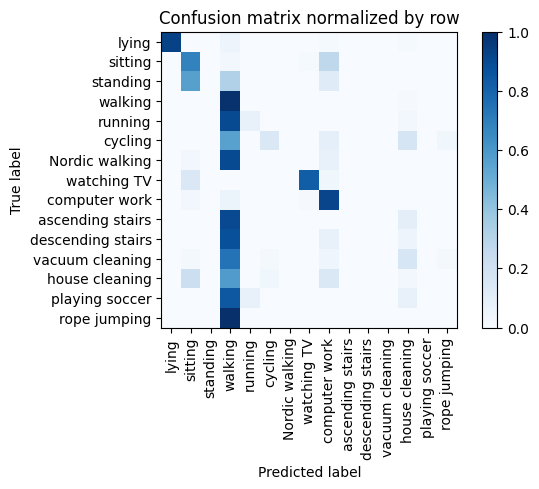

Training Epoch:  10%|█         | 1/10 [00:04<00:40,  4.55s/it]

Overall accuracy: 0.416



eval: 100%|██████████| 28/28 [00:00<00:00, 45.75batch/s, loss=0.166]


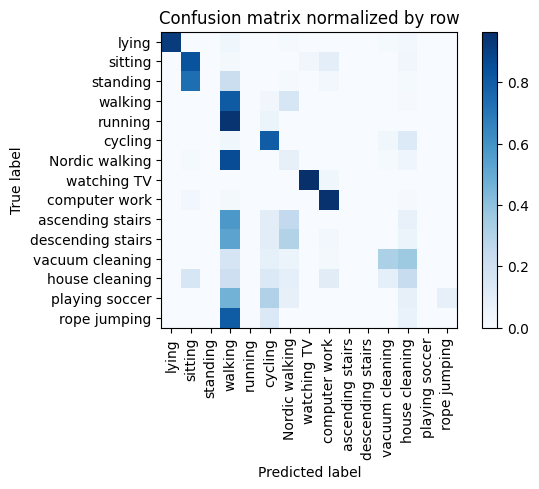

Training Epoch:  20%|██        | 2/10 [00:10<00:41,  5.23s/it]

Overall accuracy: 0.497



eval: 100%|██████████| 28/28 [00:00<00:00, 54.69batch/s, loss=0.159]


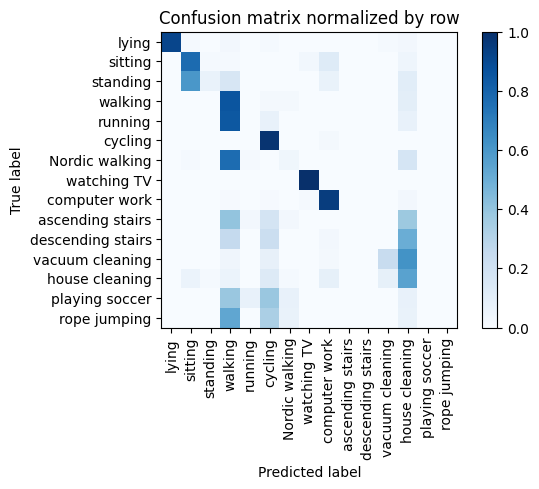

Training Epoch:  30%|███       | 3/10 [00:15<00:35,  5.06s/it]

Overall accuracy: 0.538



eval: 100%|██████████| 28/28 [00:00<00:00, 56.79batch/s, loss=0.085]


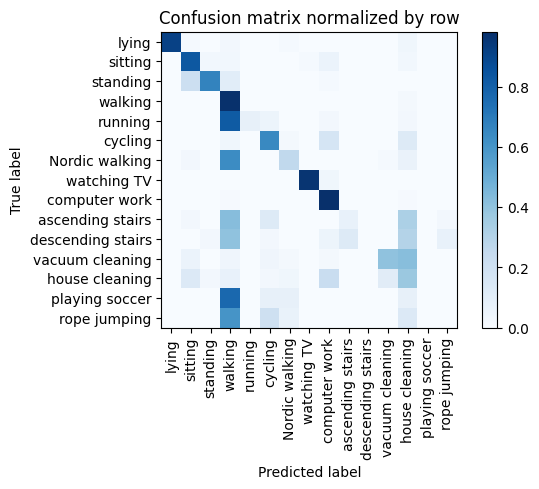

Training Epoch:  40%|████      | 4/10 [00:19<00:28,  4.83s/it]

Overall accuracy: 0.608



eval: 100%|██████████| 28/28 [00:00<00:00, 60.09batch/s, loss=0.126]


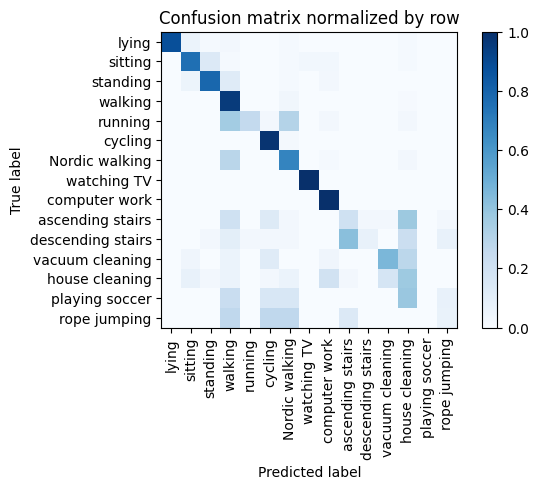

Training Epoch:  50%|█████     | 5/10 [00:23<00:23,  4.67s/it]

Overall accuracy: 0.688



eval: 100%|██████████| 28/28 [00:00<00:00, 55.22batch/s, loss=0.108]


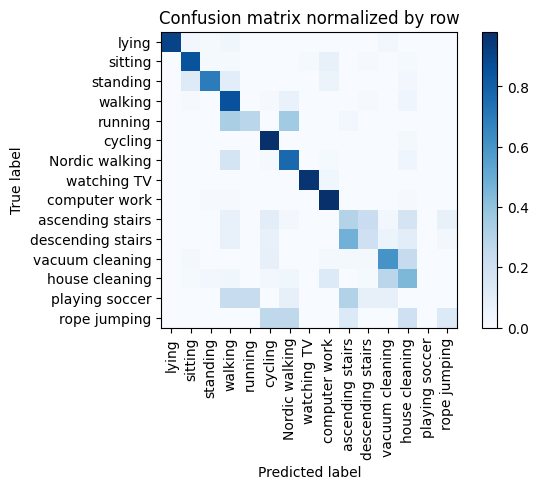

Training Epoch:  60%|██████    | 6/10 [00:28<00:18,  4.58s/it]

Overall accuracy: 0.710



eval: 100%|██████████| 28/28 [00:00<00:00, 46.43batch/s, loss=0.0976]


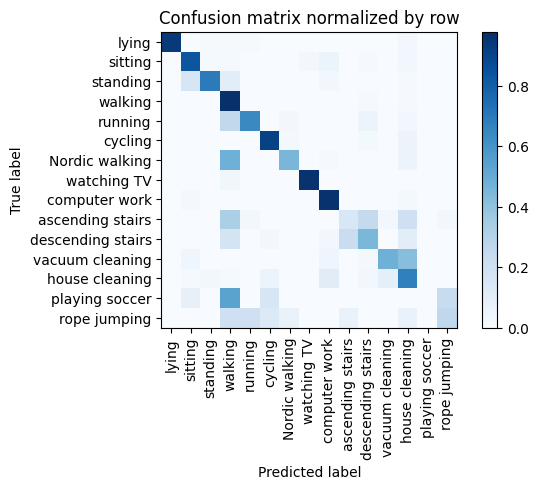

Training Epoch:  70%|███████   | 7/10 [00:32<00:13,  4.54s/it]

Overall accuracy: 0.729



eval: 100%|██████████| 28/28 [00:00<00:00, 59.96batch/s, loss=0.0862]


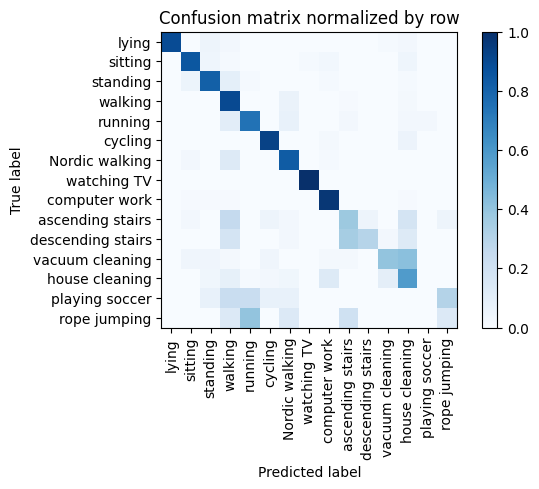

Training Epoch:  80%|████████  | 8/10 [00:37<00:09,  4.52s/it]

Overall accuracy: 0.755



eval: 100%|██████████| 28/28 [00:00<00:00, 59.96batch/s, loss=0.228]


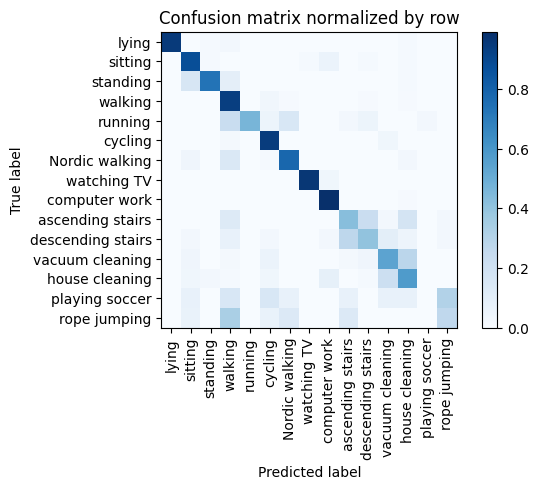

Training Epoch:  90%|█████████ | 9/10 [00:41<00:04,  4.54s/it]

Overall accuracy: 0.763



eval: 100%|██████████| 28/28 [00:00<00:00, 56.00batch/s, loss=0.0509]


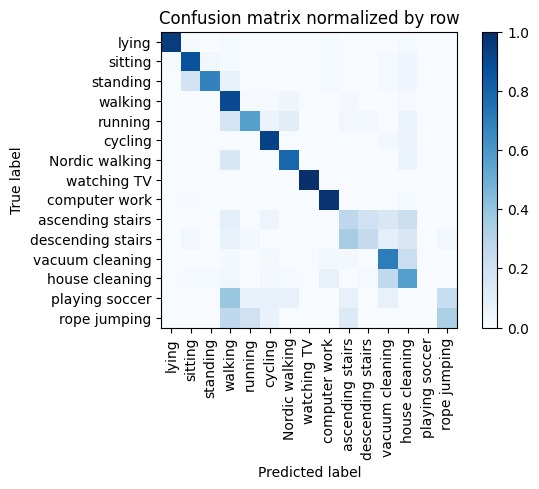

Overall accuracy: 0.753



eval: 100%|██████████| 19/19 [00:00<00:00, 77.24batch/s, loss=0.369]


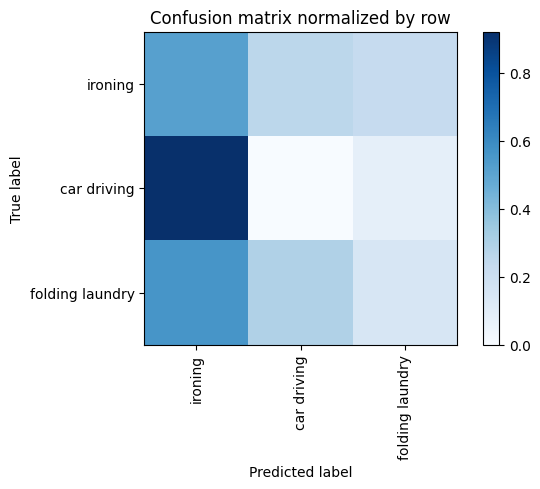

Overall accuracy: 0.346

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.524      0.515      0.520      0.596        357|	 car driving: 0.258,	folding laundry: 0.227,	
folding laundry       0.207      0.149      0.174      0.257        154|	 ironing: 0.558,	car driving: 0.292,	
    car driving       0.000      0.000      0.000      0.147         88|	 ironing: 0.920,	folding laundry: 0.080,	

----------------------------------------------------------------------------------------------------
    avg / total       0.366      0.346      0.354        1.0        599|	      

{'total_accuracy': 0.34557595993322204, 'precision': 0.24380791047457714, 'recall': 0.2215856039385451, 'f1': 0.23111963898660412}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.331913
precision         0.293415
recall            0.290602
f1                0.255826
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model2(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len)
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    

In [10]:
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df

,total_accuracy,precision,recall,f1
0,0.405251,0.406286,0.384697,0.331028
1,0.390607,0.409970,0.309320,0.312458
2,0.414480,0.347685,0.379560,0.322954
3,0.103650,0.059325,0.157846,0.081572
4,0.345576,0.243808,0.221586,0.231120


In [11]:
seen_score_df.mean()

total_accuracy    0.331913
precision         0.293415
recall            0.290602
f1                0.255826
dtype: float64